# Assignment 2 Part B

## Harmony Heals 

### Project by RAS (Group 45)
- Rohan Britto (Student ID: 24610990)
- Aaditya Deshmukh (Student ID: 14334864)
- Smit Khatri (Student ID: 24712248)

## Importing packages and data

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns

In [18]:
df = pd.read_csv('Datasets/muse_v3_lyrics.csv')

C:\Users\Rohan\AppData\Local\Temp\ipykernel_2544\1530094557.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Datasets/muse_v3_lyrics.csv')


Checking the features of the dataset

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90001 entries, 0 to 90000
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      90001 non-null  int64  
 1   lastfm_url              90001 non-null  object 
 2   track                   90001 non-null  object 
 3   artist                  90001 non-null  object 
 4   seeds                   90001 non-null  object 
 5   number_of_emotion_tags  90001 non-null  int64  
 6   valence_tags            90001 non-null  float64
 7   arousal_tags            90001 non-null  float64
 8   dominance_tags          90001 non-null  float64
 9   mbid                    61217 non-null  object 
 10  spotify_id              61630 non-null  object 
 11  genre                   83362 non-null  object 
 12  lyrics                  29842 non-null  object 
dtypes: float64(3), int64(2), object(8)
memory usage: 8.9+ MB


Let us check if there are any duplicates

In [20]:
df.duplicated().unique()

array([False])

In [21]:
print("The maximum valence number in the dataset is ", df['valence_tags'].max(), " and the minimum is ", df['valence_tags'].min())

The maximum valence number in the dataset is  8.475  and the minimum is  0.235


## Data Cleaning

Copying the dataframe so that it can be restored if there is any error

In [5]:
df_cleaned = df.copy()

Dropping columns that we will not be using for this experiment

In [6]:
df_cleaned = df.drop(['ID','lastfm_url','seeds','spotify_id','genre','mbid'], axis=1)

We will use only those rows that have lyrics populated in them. Rows with null values, Not Found, Not English and Exception in lyrics column need to be deleted.

In [7]:
df_cleaned = df_cleaned[~df_cleaned['lyrics'].isna()]

In [8]:
df_cleaned = df_cleaned[df_cleaned['lyrics']!='Not Found']

In [9]:
df_cleaned = df_cleaned[df_cleaned['lyrics']!='Not English']

In [10]:
df_cleaned = df_cleaned[df_cleaned['lyrics']!='Exception']

A quick look at the data after clearing the columns that are not required.

In [11]:
df_cleaned.head()

,track,artist,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,lyrics
1,St. Anger,Metallica,8,3.710000,5.833000,5.427250,St. Anger 'round my neck\r\nSt. Anger 'round m...
2,Speedin',Rick Ross,1,3.080000,5.870000,5.490000,"Legendary, Runners, you know me, o ooooh, o oo..."
3,Bamboo Banga,M.I.A.,13,6.555071,5.537214,5.691357,"Road runner, road runner\r\nGoing hundred mile..."
4,Die MF Die,Dope,7,3.771176,5.348235,5.441765,I don't need your forgiveness\r\nI don't need ...
5,Step Up,Drowning Pool,9,2.971389,5.537500,4.726389,"One, two, three, go\r\n\r\nBroken\r\nYeah, you..."


Creating a list of text columns for processing

In [12]:
text_cols = ['track','artist','lyrics']

Let us check the distribution of valence numbers in the dataset

C:\Users\Rohan\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='valence_tags', ylabel='Density'>

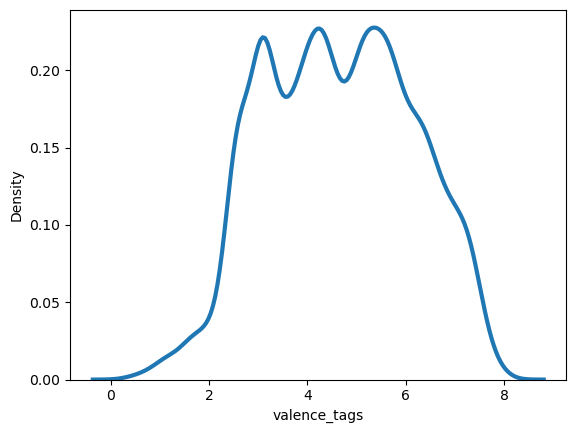

In [14]:
sns.distplot(df_cleaned['valence_tags'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3})

There seems to be a fair distribution of valence numbers in the dataset which is good.

Importing packages for tokenization

In [15]:
!pip install nltk
import nltk

from nltk.tokenize import word_tokenize

Importing packages for stopword and punctuation removal

In [132]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

import string
punctuations=list(string.punctuation)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Importing packages and building a function for part of speech recognition and lemmatization

In [133]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Rohan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


We will build a function that will tokenize the lyrics into words, remove stopwords and punctuations and also lemmatize the words.

- Tokenization is the process of breaking down a text into sentences/words
- Stopwords and punctuations do not carry much meaning in the text and hence, need to be removed before training the model
- Lemmatization is the process of breaking down a word to its base form so that words with the 

In [134]:
# Function defined to tokenize text, remove stopwords and punctuation and lemmatize words
def process_text(text):
    # Word tokenization
    words = nltk.word_tokenize(text)
    # Lemmatization, Stopword and punctuation removal
    words = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word)) for word in words if word.lower() not in stop_words and word not in punctuations]
    return words

Let us apply the function to the three main textual features of our dataset. We will be using only these to try and predict a valence score.

In [135]:
for col in text_cols:
    df_cleaned[col] = df_cleaned[col].apply(process_text)

Let us have a look at the data after tokenization

In [136]:
df_cleaned.head()

,track,artist,number_of_emotion_tags,valence_tags,arousal_tags,dominance_tags,lyrics
1,"[st., anger]",[metallica],8,3.710000,5.833000,5.427250,"[st., anger, 'round, neck, st., anger, 'round,..."
2,[speedin],"[rick, ross]",1,3.080000,5.870000,5.490000,"[legendary, runner, know, ooooh, ooooh, trilla..."
3,"[bamboo, banga]",[m.i.a],13,6.555071,5.537214,5.691357,"[road, runner, road, runner, go, hundred, mile..."
4,"[die, mf, die]",[dope],7,3.771176,5.348235,5.441765,"[n't, need, forgiveness, n't, need, hate, n't,..."
5,[step],"[drown, pool]",9,2.971389,5.537500,4.726389,"[one, two, three, go, broken, yeah, livin, edg..."


Let us now use word embedding to convert words into vectors so that we can use them to train models. We have used the twitter glove model as we believe that tweets can have both formal and casual/slang languages, which might be the case in lyrics of a song as well

In [137]:
from gensim.models import KeyedVectors
import gensim.downloader as api
from pathlib import Path

filepath = Path('bin/glove_twitter_50.d2v')

if filepath.is_file():
    w2vmodel = KeyedVectors.load("bin/glove_twitter_50.d2v")
else:
    w2vmodel = api.load('glove-twitter-50')
    w2vmodel.save('bin/glove_twitter_50.d2v')

Let us have a quick glimpse of how the model responds to contractions/slang words found in our dataset

In [138]:
w2vmodel.most_similar('livin', topn=10)

[('stayin', 0.8281562328338623),
 ('nothin', 0.7884376049041748),
 ('lovin', 0.7804484963417053),
 ('thinkin', 0.7743610143661499),
 ('feelin', 0.7609580755233765),
 ('spendin', 0.7592039108276367),
 ('movin', 0.756058931350708),
 ('living', 0.7520089745521545),
 ('grindin', 0.7500482201576233),
 ('keepin', 0.744117796421051)]

It returned pretty good results.

Let us define a function to convert words to vectors. This function will be used on lyrics, artist name and track name.

In [139]:
def convert_w2v(words):
    vocab_words = [word for word in words if word in w2vmodel.index_to_key]
    if vocab_words:
        vec = np.mean(w2vmodel[vocab_words], axis=0)
    else:
        vec = np.zeros(w2vmodel.vector_size)
        
    return vec

In [140]:
df_vec = pd.DataFrame()
for col in text_cols:
    df_vec[col] = df_cleaned[col].apply(convert_w2v)

Let us have a glimpse of the data after vector conversion

In [141]:
df_vec.head()

,track,artist,lyrics
1,"[0.165115, 0.047045022, 0.011944994, -0.047220...","[-1.5121, 0.56089, 0.31079, 0.5117, -0.37686, ...","[-0.18695752, 0.09429084, 0.21492447, 0.041842..."
2,"[-2.5112, 0.2019, 0.41856, -0.51534, -0.26289,...","[-0.68313503, -0.41352, 0.458995, -0.807595, -...","[-0.13528791, 0.086075895, 0.00049746176, -0.0..."
3,"[-0.734945, -0.0005199909, 0.420065, -0.242645...","[-1.8619, 0.57832, -0.11964, -0.21855, -0.3286...","[-0.14192171, 0.22574994, 0.19820145, -0.42629..."
4,"[0.44762668, 1.00113, -0.2718633, -0.45729664,...","[-0.41516, -0.01654, -0.089277, -0.29688, 1.64...","[0.36944926, 0.4410963, -0.23828115, -0.190674..."
5,"[-0.39883, -0.050333, 0.30032, -0.44223, 0.581...","[-0.99039, 0.443645, 0.663595, -0.284985, 0.00...","[0.11768429, 0.2919641, 0.32031235, -0.2069796..."


## Dimensionality Reduction

In [143]:
from sklearn.decomposition import PCA

In [144]:
def pca_transform(vec):
    n_components = 30
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(vec)
    pca_cols = ['PCA'+col+str(i) for i in range(1, n_components+1)]
    df_ret = pd.DataFrame(data=pca_data, columns=pca_cols)
    
    return df_ret

In [145]:
df_pca = pd.DataFrame()
for col in text_cols:
    df_temp = pca_transform(df_vec[col].tolist())
    df_pca = pd.concat([df_pca, df_temp], axis=1)

(15085, 30)
(15085, 30)
(15085, 30)


In [148]:
df_cleaned.drop(text_cols, inplace=True, axis=1)

In [191]:
df_pca.reset_index(drop=True,inplace=True)
df_cleaned.reset_index(drop=True,inplace=True)
df_cleaned = pd.concat([df_cleaned,df_pca], axis=1)

In [192]:
df_cleaned.shape

(15085, 94)

Now we will move the dependent variable, i.e. valence tags in our case, to the y variable.

In [193]:
y = df_cleaned.pop('valence_tags')

We will copy the remaining features to our X variable.

In [194]:
X = df_cleaned.copy()

## Test Train Split

As we have a huge dataset, we have decided to use 70% for training and 30% for testing. The testing set is further divided into 60% for validation and 40% for final testing.

In [195]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=8)

We will download the split data into separate pickle files so that we can directly use them in our further experiments.

In [197]:
pd.to_pickle(X_train, 'Datasets/X_train.pkl')
pd.to_pickle(X_val, 'Datasets/X_val.pkl')
pd.to_pickle(X_test, 'Datasets/X_test.pkl')

pd.to_pickle(y_train, 'Datasets/y_train.pkl')
pd.to_pickle(y_val, 'Datasets/y_val.pkl')
pd.to_pickle(y_test, 'Datasets/y_test.pkl')